In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import plotly.express as px
from sklearn.preprocessing import StandardScaler,LabelEncoder
import plotly.graph_objects as go
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split,KFold, GroupKFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight
from mlxtend.classifier import EnsembleVoteClassifier
import xgboost as xgb 

<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> 1. Introduction </h1>

I wanted to create this notebook because this is good chance to play with PCA. Instead of using prepared fuctions I wanted o make it from scratch explaining how it works. You can play with it and if you like upvote:) <br>
My personal goal is to make the notebooks prettier instead of .py code :) 

<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> 2. Initial Setup-Data Preparaton </h1>


In [ ]:
# Initialize local variables

SEED = 1992
TARGET = ['target']
SAMPLE = 2000 #For Visualization purposees

In [ ]:
# Import the data and prepare for the analysis. I have used sampling for speed up purposes. You can remove it :)

train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')

#Prepare train and test dataset
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

#Checking the null Data
null_data = (train.isna().sum().sort_values(ascending=False) / len(train) * 100) 
fig, ax = plt.subplots(1,1,figsize=(35, 7)) 
ax.bar(null_data.index, 100, color='#dadada', width=0.6) 
bar = ax.bar(null_data.index,null_data, width=0.6) 
ax.bar_label(bar, fmt='%.01f %%') 
ax.spines.left.set_visible(False) 
ax.set_yticks([]) 
ax.set_title('Null Data Ratio', fontweight='bold') 
plt.show()

train.describe().drop('count').T\
        .style.bar(subset=['mean'])\
        .background_gradient(subset=['std'])\
        .background_gradient(subset=['50%'])\
        .background_gradient(subset=['max'])

In [ ]:
# Combining all df to make the same preprocessing.

#Encode the string data
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)


all_df = pd.concat([train, test]).reset_index(drop=True)
all_df[TARGET]=label_encoder(all_df[TARGET])
train_last_id = train.shape[0]

X = all_df.drop(TARGET,axis=1)
y = all_df[TARGET]
print('Feature dataset format:\t{}\nTarget dataset format:\t{}\nTrain dataset size:\t{}'.format(X.shape,y.shape,train_last_id))

In [ ]:
# Check the Class distribution
px.histogram(y, x=TARGET,title='Class Weight Histogram')

Data Looks highly unbalanced thus the class balance method needs to be adjusted.

In [ ]:
# Calculate the classes weights
class_ratio = class_weight.compute_class_weight('balanced', y.target.unique(), y.target)
print(class_ratio)

<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> 3. PCA Pipeline - Step by step how it works</h1>

To begin the PCA analysis you have to ensure that the Eigendecomposition will be not affected by the scale of the values 

<h1 style="background-color:#6B6B6B; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;">Basics Terms</h1>
To undrstand the PCA we need some basic knowledge about the following terms<br>
**Variance** = Spread of data around the Mean<br>
<br>
**Covariance** = Relation direction beween two random variables<br>
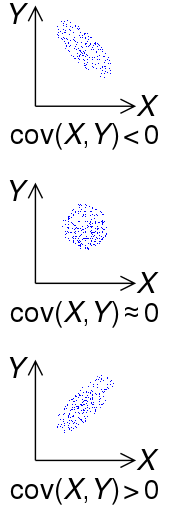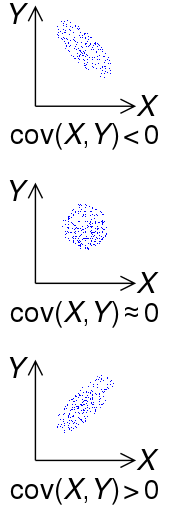
<br>
**Correlation** = Measure that shows us when one variable is changining how another variables/s results are affected.
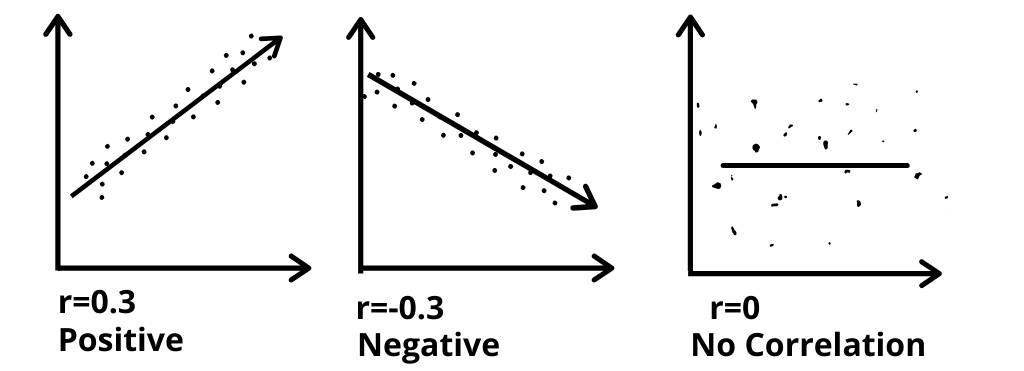!

In [ ]:

X_scaled = StandardScaler().fit_transform(X)

# Presentation of scaled variables
print('Not Scaled Values:\n{}\n\nScaled Values:\n{}'.format(X[:1].values,X_scaled[:1]))


In [ ]:
#Creation of covariation matrix and checkig if variables are internally covariated

corr = X.corr().abs()

data = go.Heatmap(
        z=corr.values,
        x=corr.index.values,
        y=corr.columns.values,
        zmin=0,
        zmax=0.05)

layout = go.Layout(title='Covariance matrix - Internal noise detection',
                   yaxis_autorange='reversed',
                   xaxis_showgrid=False,
                   yaxis_showgrid=False
                  ) 

fig = go.Figure(data=data,layout=layout) 
fig.show()

As we can see the data is not internally correlated thus all variables can be used in features selecton. Internal correlation may leads to strong correlation and covariation signals making other relations underated

<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> 3a. PCA Pipeline - Features Selection</h1>
We will make Levene's significnce test to check equality of variances. Non-signifant p-value = variances are indeed euqal and there is no difference in variances of both groups.
Basically we want to get rid of features where nothing interesting is happening (denoising of low variance features)


<h1 style="background-color:#6B6B6B; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;">Covariance matrix by numpy.cov </h1>


[Documentation](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)<br>
Estimate a covariance matrix, given data and weights.

Covariance indicates the level to which two variables vary together. If we examine N-dimensional samples, X = [x_1, x_2, ... x_N]^T, then the covariance matrix element C_{ij} is the covariance of x_i and x_j. The element C_{ii} is the variance of x_i.

In [ ]:
features = X_scaled.T
cov_matrix = np.cov(features,bias=False)
values, eig_vectors = np.linalg.eig(cov_matrix)
values[:10]

In [ ]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(np.sum(explained_variances), explained_variances)

In [ ]:
projected_1 = X_scaled.dot(eig_vectors.T[0])
projected_2 = X_scaled.dot(eig_vectors.T[1])
projected_3 = X_scaled.dot(eig_vectors.T[2])
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['PC3'] = projected_3 # You can create as many vectors you want
res['Y'] = y

# In the output you will get the vectors as new fetures. You can use it for the training
res.head()


<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> 3b. PCA Pipeline - PCA Visualization</h1>


In [ ]:
#  Plot the sample vectors
SC_DATA = res[:train_last_id].sample(SAMPLE)
SC_DATA["Y"] = SC_DATA["Y"].astype(str)

fig = px.scatter(SC_DATA, x='PC1', y='PC2',color='Y',title='PC1 vs PC2 vectors plot',opacity=0.9)
fig.show()
fig = px.scatter(SC_DATA, x='PC2', y='PC3',color='Y',title='PC2 vs PC3 vectors plot',opacity=0.9)
fig.show()

In [ ]:
 X_scaled.dot(eig_vectors)

In [ ]:
fig = px.scatter_3d(res[:train_last_id].sample(SAMPLE), x='PC1', y='PC2',z='PC3',color='Y',size_max=10,opacity=0.6,title='PC1 PC2 PC3 vector 3d plot')
fig.show()

<h1 style="background-color:#6B6B6B; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;">Let`s combine everything together </h1>

All these tutorial wrapped up into single functon I hope I have presented the PCA analysis in the easy way :)<br>
We will start from the feature selecton. For this purposes we will use the custom model as selector

In [ ]:
#Feature Selection
X_to_select = X[:train_last_id]
y_to_select = y[:train_last_id]

In [ ]:
# Crate selector instance
estimator = CatBoostClassifier(verbose=False)
selector = SelectFromModel(estimator=estimator).fit(X_to_select, y_to_select)

# Calculate stimator coeficient The treshold will be used to keep/discard the variables for LogisticRegression
#selector.estimator_.coef_[0]

In [ ]:
# Get selector result
selector_results = np.unique(selector.get_support(),return_counts=True)

print('#'*50)
print("After Variable Selection for PCA:\n\tVariables keeped:\t{}\n\tVariables removed:\t{}\n\tImportance threshold:\t{}"\
      .format(selector_results[1][1],selector_results[1][0],selector.threshold_))
print('#'*50)

# Apply the selection
X_transformed = selector.transform(X_to_select)

In [ ]:
# Combine everything together
def PCA(X , num_components):
     
    # Part 1 Scaling the data
    scaledX = StandardScaler().fit_transform(X)
     
    #Creation of covariance matrix
    cov_mat = np.cov(scaledX , rowvar = False)
     
    #Calculate Eigenvectors and Eigenvalues wrap function - Hermitian or symmetric matrix
    '''
    Hermitian matix (Dirac matrix):
    1,0,0,0
    0,1,0,0
    0,0,-1.0
    0,0,0,-1
    
    Symmetric matrix:
    1,a,b
    a,2,c
    b,c,3
    
    np.linalg.eigh will solve both cases - no need to make exceptions
    '''
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Descending order sort
    sorted_index = np.argsort(eigen_values)[::-1] # sorting the same shape
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Subset from the matrxc
    eigenvector_sub = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_sub.transpose() , scaledX.transpose() ).transpose()
    
    # Create Labels automaticaly
    column_labels = []
    for i in range(num_components):
        column_labels.append('PC_{}'.format(i+1))
    
    
    return X_reduced,column_labels

mat_reduced,col_labels = PCA(X_transformed,4)
#Creating DataFrame of reduced Dataset
PCA_DF = pd.DataFrame(mat_reduced , columns = col_labels)
 
#Concat with target
PCA_DF = pd.concat([PCA_DF , y] , axis = 1)


<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> 4. Prediction setup</h1>
Now I will create the simple pipeline of using the catboost model to make the prediction basing on the PCA components

In [ ]:
lgbm_params = {
    'n_estimators': 45000,
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    'random_state': SEED,
    'learning_rate': 0.02,
    'min_child_samples': 150,
    'reg_alpha': 750,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 3,#16
    'colsample_bytree': 0.15,
    'subsample': 0.7,
    'subsample_freq': 2,
    'max_bin': 240,
    'device':'gpu',
    'class_weights':class_ratio
}

cols = list(PCA_DF.columns)
cols.remove("target")

PCA_train = PCA_DF[:train_last_id]
PCA_test = PCA_DF[train_last_id:]

In [ ]:
def KFoldTraining(classifier):
    test_preds = None
    train_rmse = 0
    val_rmse = 0
    n_splits = 5

    classifier = classifier
    

    kf = KFold(n_splits = n_splits , shuffle = True , random_state = 42)
    for fold, (tr_index , val_index) in enumerate(kf.split(PCA_train[cols].values , PCA_train['target'].values)):

        print("-" * 50)
        print(f"Fold {fold + 1}")

        x_train,x_val = PCA_DF[cols].values[tr_index] , PCA_train[cols].values[val_index]
        y_train,y_val = PCA_DF['target'].values[tr_index] , PCA_train['target'].values[val_index]

        eval_set = [(x_val, y_val)]

        model = classifier
        model.fit(x_train, y_train, eval_set = eval_set, verbose = 1000)

        train_preds = model.predict(x_train)
        train_rmse += mean_squared_error(y_train ,train_preds , squared = False)
        print("Training RMSE : " , mean_squared_error(y_train ,train_preds , squared = False))

        val_preds = model.predict(x_val)
        val_rmse += mean_squared_error(y_val , val_preds , squared = False)
        print("Validation RMSE : " , mean_squared_error(y_val , val_preds , squared = False))

        if test_preds is None:
            test_preds = model.predict_proba(PCA_test[cols].values)
        else:
            test_preds += model.predict_proba(PCA_test[cols].values)

    print("-" * 200)
    print("Average Training RMSE : " , train_rmse / n_splits)
    print("Average Validation RMSE : " , val_rmse / n_splits)

    test_preds /= n_splits
    return test_preds

<h1 style="background-color:#6B6B6B; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;">Model Ensembling</h1>

Ensemble the 2 classifiers and make final prediction by averaging the predictions made by 2 models

In [ ]:
LGBM_classifier = LGBMClassifier(**lgbm_params)
#XGB_classifier = xgb.XGBClassifier(eval_metric='mlogloss')#Can be optimized :)


CB_pred = KFoldTraining(LGBM_classifier)
#XGB_pred = KFoldTraining(XGB_classifier) I have to make the balanced training on XGB - Feature soon
test_preds = CB_pred.copy() # Next I will make model ensembing

<h1 style="background-color:#6B6B6B; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;">Submission Creation </h1>


In [ ]:
sample_submission['Class_1']=test_preds[:,0]
sample_submission['Class_2']=test_preds[:,1]
sample_submission['Class_3']=test_preds[:,2]
sample_submission['Class_4']=test_preds[:,3]
sample_submission.head()

In [ ]:
sample_submission.to_csv("PCA_sample2.csv",index=False)

<h1 style="background-color:#A50034; font-family:segoeui; font-size:200%; text-align:center; border-radius: 15px 50px;"> Notebook development plan</h1>

# If you like the notebook I will be happy. This motivate me to develop it :) <br>
# Plans
- More visualization
- PCA ensembling
- The ideas in comments<br>

Lets connect on [LinkedIn](https://www.linkedin.com/in/marcinstasko/?locale=en_US) :)